<a href="https://colab.research.google.com/github/zikribayraktar/GANs_Exercises/blob/master/Keras_Example_Variational_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Variational Autoencoder Examples in Keras**

Refer to the 'GANs In Action' book.

https://keras.io/datasets/

In [0]:
### USE THIS TO KILL THE VIRTUAL MACHINE BEFORE CLOSING THIS COLAB NOTEBOOK:

!kill -9 -1

In [0]:
## Step 1: Mount Google Drive:

##Hidden from public
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
## Step 2: change directory to where your notebooks are:

import os
cwd = os.getcwd()
os.chdir("drive/My Drive/Colab Notebooks")
print(cwd)
#!ls -ltr

/content


In [3]:
# Test to see if we have access to GPU

import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
# Import some libraries to use:

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [0]:
# Set some variables and hyperparameters:
batch_size = 50
original_dim = 28*28
latent_dim = 2
interm_dim = 256
nb_epoch = 100
eps_std = 1.0

In [0]:
def sampling(args):
  z_mean, z_log_var = args
  epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.0)
  return z_mean + K.exp(z_log_var/2)*epsilon

In [0]:
# Let's setup the Encoder (using functional API):

### input layer
x = Input(shape=(original_dim, ), name='input')
### intermediate layer
h = Dense(interm_dim, activation='relu', name='encoding')(x)
### mean of the latent space
z_mean = Dense(latent_dim, name='mean')(h)
### log-variance of the latent space
z_log_var = Dense(latent_dim, name='log-variange')(h)
### using Lambda, call the sampling function to create the latent space sampling
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
### define Encoder as Keras model:
encoder = Model(x, [z_mean, z_log_var, z], name='encoder')

In [0]:
# Let's setup the Decoder:

### input layer
decoder_input = Input(shape=(latent_dim,), name='decoder_input')
### intermediate layer
decoder_h = Dense(interm_dim, activation='relu', name='decoder_h')(decoder_input)
### getting back to original dimension
x_decoded = Dense(original_dim, activation='sigmoid', name='flat_decoded')(decoder_h)
### define Decoder as Keras model:
decoder = Model(decoder_input, x_decoded, name='decoder')

In [11]:
# Let's combine Encoder and Decoder into single VAE model:

### decoder model takes in the z coming out of encoder:
output_combined = decoder(encoder(x)[2])
### VAE model:
vae = Model(x, output_combined)
### print VAE summary:
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 201988    
_________________________________________________________________
decoder (Model)              (None, 784)               202256    
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________


In [0]:
# define the loss function:

def vae_loss(x:tf.Tensor, x_decoded_mean:tf.Tensor):
  xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
  kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis =-1)
  return xent_loss + kl_loss

In [0]:
# complete the model:
vae.compile(optimizer='rmsprop', loss=vae_loss)

In [31]:
### Keras provides some datasets:
### https://keras.io/datasets/

from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

#from keras.datasets import fashion_mnist
#(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

11493376/11490434 [==============================] - 1s 0us/step


In [32]:
x_train[0].shape

(28, 28)

In [33]:
# We will normalize all values between 0 and 1 and we will flatten the 28x28 
# images into vectors of size 784.

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print (x_train.shape)
print (x_test.shape)

(60000, 784)
(10000, 784)


In [34]:
vae.fit(x_train, x_train,
        epochs=nb_epoch,
        batch_size=batch_size,
        shuffle=True,
        validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 5s 80us/step - loss: 182.6753 - val_loss: 172.7161
Epoch 2/100
60000/60000 [==============================] - 5s 82us/step - loss: 171.0685 - val_loss: 167.6821
Epoch 3/100
60000/60000 [==============================] - 5s 82us/step - loss: 166.6647 - val_loss: 164.5073
Epoch 4/100
60000/60000 [==============================] - 5s 82us/step - loss: 163.8725 - val_loss: 162.6899
Epoch 5/100
60000/60000 [==============================] - 5s 82us/step - loss: 162.1693 - val_loss: 161.4258
Epoch 6/100
60000/60000 [==============================] - 5s 82us/step - loss: 160.9365 - val_loss: 160.5297
Epoch 7/100
60000/60000 [==============================] - 5s 82us/step - loss: 159.9975 - val_loss: 159.5907
Epoch 8/100
60000/60000 [==============================] - 5s 82us/step - loss: 159.1537 - val_loss: 159.0467
Epoch 9/100
60000/60000 [==============================] - 5s 81us/ste

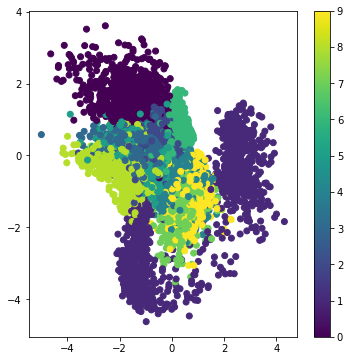

In [42]:
# Display
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)[0]
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c=y_test, cmap='viridis')
plt.colorbar()
plt.show()

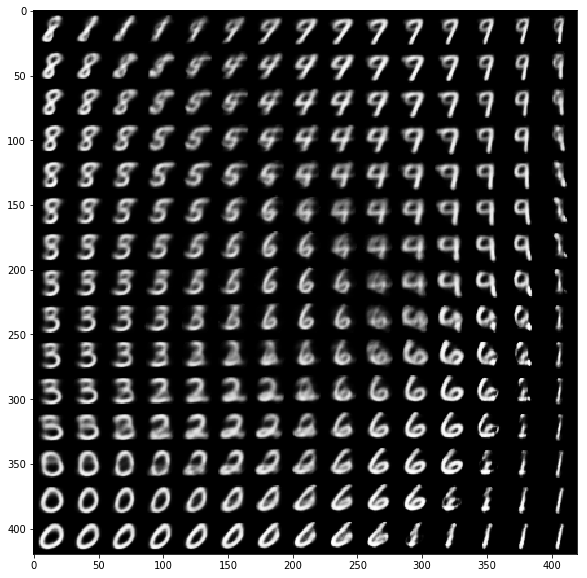

In [44]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()